#**Sales - Data Analysis Using PySpark**

**Installed PySpark**

In [ ]:
# Installing Pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=edddbeeb4c1e7b9174fcab29241b03a31d798d2e65a4d61968ce6dcdcfc17a9c
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


#**Reading Sales Data**

In [ ]:
# Libraries
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer

# Data Visualization
import matplotlib.pyplot as plt

In [ ]:
# Crearting spark session
spark = SparkSession.builder.appName("Sales Data Analysis").getOrCreate()

In [ ]:
# Reading Sales CSV file
df = spark.read.csv("/content/drive/MyDrive/Dataset/sales_data_sample.csv", header=True)

# Display Data
df.show()

+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|        CUSTOMERNAME|           PHONE|        ADDRESSLINE1|ADDRESSLINE2|         CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|      10107|             30|     95.7|              2|   2871| 2/24/2003

In [ ]:
# Sales Data Structure
df.printSchema()

root
 |-- ORDERNUMBER: string (nullable = true)
 |-- QUANTITYORDERED: string (nullable = true)
 |-- PRICEEACH: string (nullable = true)
 |-- ORDERLINENUMBER: string (nullable = true)
 |-- SALES: string (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: string (nullable = true)
 |-- MONTH_ID: string (nullable = true)
 |-- YEAR_ID: string (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: string (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = true)
 |-

In [ ]:
# Sales Data Description
df.describe().show()

+-------+------------------+-----------------+------------------+-----------------+------------------+--------------+---------+------------------+------------------+------------------+------------+------------------+-----------+-----------------+--------------------+--------------------+------------+------------+--------+------------------+---------+---------+---------------+----------------+--------+
|summary|       ORDERNUMBER|  QUANTITYORDERED|         PRICEEACH|  ORDERLINENUMBER|             SALES|     ORDERDATE|   STATUS|            QTR_ID|          MONTH_ID|           YEAR_ID| PRODUCTLINE|              MSRP|PRODUCTCODE|     CUSTOMERNAME|               PHONE|        ADDRESSLINE1|ADDRESSLINE2|        CITY|   STATE|        POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-------+------------------+-----------------+------------------+-----------------+------------------+--------------+---------+------------------+------------------+------------------+------

#**Preprocess Sales Data**

**Checking Nulls Values**

Total Nulls Count :  {'ADDRESSLINE2': 2521, 'STATE': 1486, 'POSTALCODE': 76}




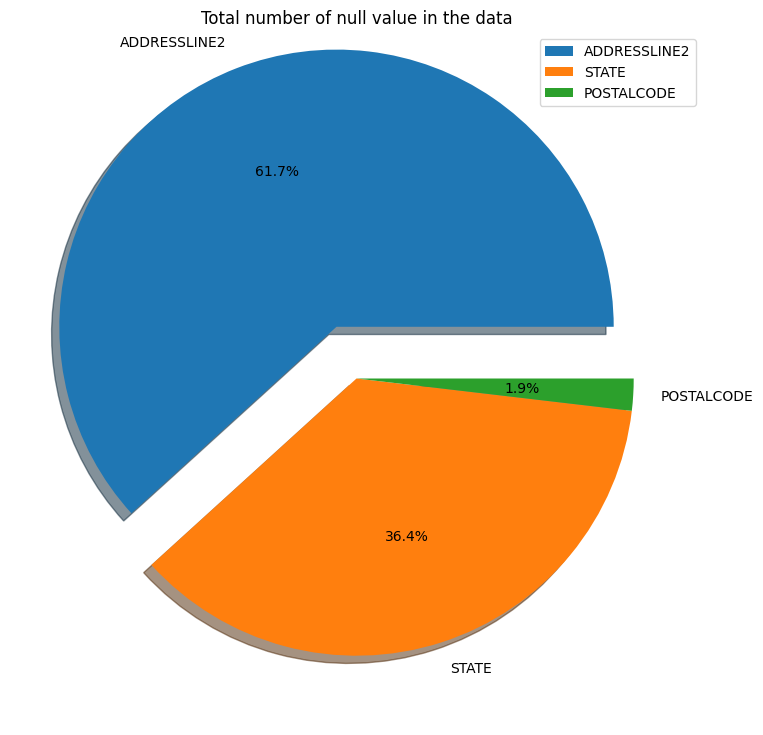

In [ ]:
# Empty Dictionary
nulls = {}

# Counting nulls by columns
for i in df.columns:
  if df.filter(df[i].isNull()).count() != 0:
    nulls[i] = df.filter(df[i].isNull()).count()

# Display Data
print('Total Nulls Count : ',nulls)

print("\n")

# Pie Chart
plt.rcParams["figure.figsize"] = (10,9)
columns = [i for i in nulls]
myExplode = [0.2,0,0]
plt.pie(nulls.values(), labels = columns, explode = myExplode, shadow = True, autopct = '%1.1f%%')
plt.title('Total number of null value in the data')
plt.legend()
plt.show()

**Checking Duplciate Values**

In [ ]:
df.groupby(df.columns).count().where(col('count') > 1).select(sum('count').alias('Duplicate_Count')).show()

+---------------+
|Duplicate_Count|
+---------------+
|           NULL|
+---------------+



**Numeric & Categorical Columns**

In [ ]:
# Empty List
numeric = []
categorical = []

for i in df.columns:
  if df.select(i).dtypes[0][1] != 'string':
    numeric.append(i)
  else:
    categorical.append(i)

# Display Data
print("Numeric Columns : ", numeric)
print("\nCategorical Columns : ", categorical)

Numeric Columns :  []

Categorical Columns :  ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']


**Drop Nulls**

In [ ]:
# Checking NULLs By Columns
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+---------------+---------+---------------+-----+---------+------+------+--------+-------+-----------+----+-----------+------------+-----+------------+------------+----+-----+----------+-------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|SALES|ORDERDATE|STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERNAME|PHONE|ADDRESSLINE1|ADDRESSLINE2|CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-----+---------+------+------+--------+-------+-----------+----+-----------+------------+-----+------------+------------+----+-----+----------+-------+---------+---------------+----------------+--------+
|          0|              0|        0|              0|    0|        0|     0|     0|       0|      0|          0|   0|          0|           0|    0|           0|        2521|   0| 1486|        76|      0|        0|       

In [ ]:
# NOTE: Commected below code in order to explore "Handle missing value with imputation".
# Drop NULLs
# df = df.dropna()

# Display Nulls By Columns
# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

**Handle missing value with imputation**

---
For numeric columns

1.   Mean
2.   Median
3.   Mode


For categorical

1.  Frequent category imputation

In [ ]:
# Fetching numeric columns name
columns_name = [i for i in df.columns if df.select(i).dtypes[0][1] != "string"]
columns_name
# # Imputation
# imputer = Imputer(inputCols = columns_name, outputCols = [j for j in columns_name]).setStrategy("mean")

# # Imputation Fit & Transform
# df2 = imputer.fit(df).transform(df)

# # Display Data
# df2.show()

[]

In [ ]:
# Fetching string columns
columns_name = [i for i in df.columns if dict(df.dtypes)[i] == "string"]

# Imputation
for i in columns_name:
    tmp_col = df.groupby(i).count()
    tmp_col = tmp_col.dropna(subset=[i])
    frequent_category = tmp_col.orderBy(tmp_col['count'].desc()).collect()[0][0]
    df = df.fillna({i: frequent_category})  # Fill missing values in column i with the most frequent category

df.show()

+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|        CUSTOMERNAME|           PHONE|        ADDRESSLINE1|ADDRESSLINE2|         CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|      10107|             30|     95.7|              2|   2871| 2/24/2003